## Aluno: Ricardo Hideo Sahara

In [2]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import pandas as pd
import pickle as pk
import os

Carregar o conjunto de dados de dígitos.

In [3]:
# Carregar o dataset digits
digits = load_digits()
X = digits.data
y = digits.target

# Dividir o dataset em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print("Tamanho da matriz de dados de treino: ", X_train.shape)
print("Tamanho da matriz de dados de teste:", X_test.shape)

Tamanho da matriz de dados de treino:  (1437, 64)
Tamanho da matriz de dados de teste: (360, 64)


#### Exercício 1 - Treinamento do modelo baseado em árvore de decisão
Neste exercício, você irá treinar um modelo de árvore de decisão utilizando o conjunto de dados MNIST. O objetivo é entender como funciona o processo de treinamento de um modelo de árvore de decisão e como ajustar os parâmetros para melhorar o desempenho do modelo.

**Você irá:**
1. Carregar o conjunto de dados MNIST e pré-processar os dados, se necessário.
2. Selecionar a biblioteca ou framework que você irá utilizar (por exemplo, Scikit-learn e/ou XGBoost).
3. Configurar os parâmetros do modelo, como a profundidade da árvore, o número de características a considerar em cada nó, etc.
4. Treinar o modelo utilizando o conjunto de dados de treinamento.

*Dicas:*
- Certifique-se de que os dados estejam pré-processados corretamente antes de treinar o modelo.
- Ajuste os parâmetros do modelo, como a profundidade da árvore, para melhorar o desempenho do modelo.

In [10]:

# Criar uma Decision Tree
#decision_tree = DecisionTreeClassifier(criterion='gini', splitter='best', max_features=64, max_depth=15, in_samples_split=10, min_samples_leaf=10)
#, splitter='best', max_depth=5, min_samples_split=10, min_samples_leaf=10, min_weight_fraction_leaf=0.0, max_features=50, random_state=None, max_leaf_nodes=10, min_impurity_decrease=0.0, class_weight=None, ccp_alpha=0.0, monotonic_cst=None)


# Treinar a Decision Tree
#decision_tree.fit(X_train, y_train)

# Prever as classes para o conjunto de teste
#y_pred = decision_tree.predict(X_test)

# Imprimir a precisão da Decision Tree
#print("Precisão da árvore de decisão:", decision_tree.score(X_test, y_test))
#cm = confusion_matrix(y_test, y_pred)
#print(cm)

#print(f"Impureza total de Gini da árvore: {total_gini_impurity:.4f}")

# Definir a árvore de decisão
dt = DecisionTreeClassifier()

# Definir o espaço de busca dos hiperparâmetros
param_grid = {
    'criterion': ['gini'],               # Critério de impureza
    'max_depth': range(5, 60, 5),                # Profundidade máxima da árvore
    'min_samples_split': range(2, 20, 2),                # Mínimo de amostras para dividir um nó
    'min_samples_leaf': range(2, 20, 2)                # Mínimo de amostras em um nó folha
}

grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print(f"Melhores hiperparâmetros: {best_params}")
decision_tree = grid_search.best_estimator_
y_pred = decision_tree.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia no conjunto de teste: {accuracy:.4f}")
with open('models/decision_tree.pkl', 'wb') as pickle_file:
    pk.dump(decision_tree, pickle_file)

#print(pd.DataFrame.from_dict(grid_search.cv_results_))


Fitting 5 folds for each of 891 candidates, totalling 4455 fits


Melhores hiperparâmetros: {'criterion': 'gini', 'max_depth': 40, 'min_samples_leaf': 2, 'min_samples_split': 4}
Acurácia no conjunto de teste: 0.8528


/home/codespace/.local/lib/python3.10/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


#### Exercício 2 - Avaliação dos ganhos com a utilização de modelos Ensemble
Neste exercício, você irá avaliar os ganhos obtidos ao utilizar modelos Ensemble em comparação com o modelo de árvore de decisão simples. Você irá treinar um modelo Ensemble e comparar os resultados com o modelo de árvore de decisão treinado anteriormente.

*Dicas:*
- Utilize diferentes tipos de modelos Ensemble, como Random Forest e XGBoost, para comparar os resultados.

In [8]:
rf = RandomForestClassifier(criterion='gini')
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
with open('models/random_forest.pkl', 'wb') as pickle_file:
    pk.dump(rf, pickle_file)
print("Precisão do random forest:", rf.score(X_test, y_test))


Precisão do random forest: 0.9694444444444444


In [9]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
with open('models/xgboost.pkl', 'wb') as pickle_file:
    pk.dump(xgb, pickle_file)
print("Precisão do XGBost:", xgb.score(X_test, y_test))

Precisão do XGBost: 0.9444444444444444


#### Exercício 3 - Visualização da árvore de decisão e Medida de Impureza
Neste exercício, você irá explorar a estrutura da árvore de decisão e entender como a medida de impureza é utilizada para avaliar a qualidade das divisões nos nós da árvore. A medida de impureza é um conceito fundamental em árvores de decisão, pois ajuda a determinar a melhor forma de dividir os dados em subconjuntos menores e mais homogêneos.

**Você irá:**
1. Visualizar a árvore de decisão treinada no exercício anterior, utilizando ferramentas como o Scikit-learn ou o Graphviz.

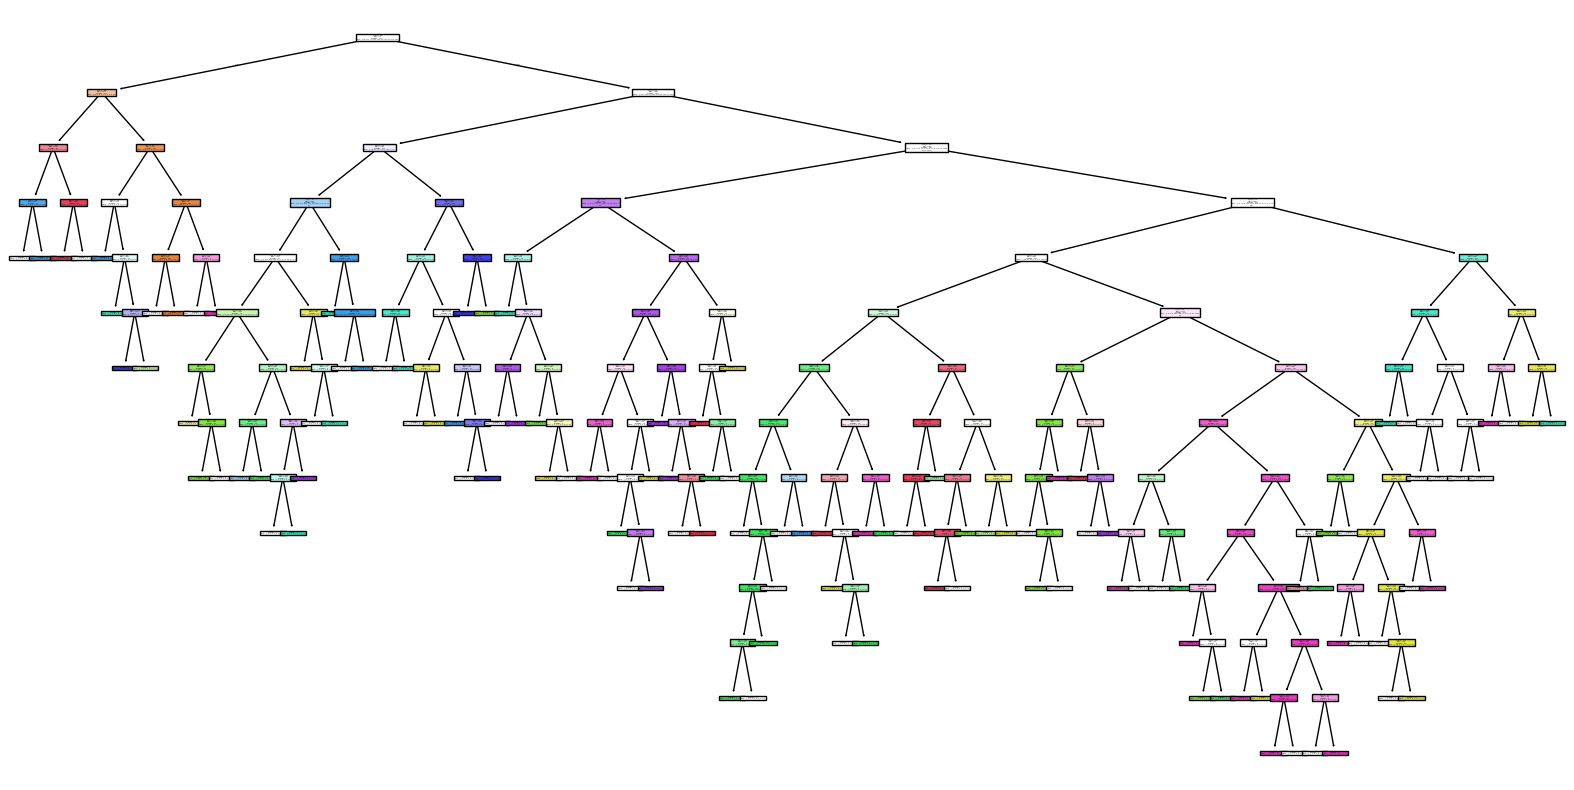

In [49]:
plt.figure(figsize=(20, 10))
tree.plot_tree(decision_tree, filled=True)
plt.show()

2. Calcular a medida de impureza para diferentes conjuntos de dados e entender como ela impacta o desempenho do modelo.

In [46]:
def gini_impurity_tree(decision_tree):
    gini_impurities = decision_tree.tree_.impurity
    samples_per_node = decision_tree.tree_.n_node_samples
    is_leaf = decision_tree.tree_.children_left == -1
    return sum(
        gini_impurities[i] * (samples_per_node[i] / samples_per_node[0]) 
        for i in range(len(gini_impurities)) if is_leaf[i]
    )

In [50]:
X_train_set = []
X_test_set = []
y_train_set = []
y_test_set = []
n = 5

for i in range(n):
    xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2)
    X_train_set.append(xtrain)
    X_test_set.append(xtest)
    y_train_set.append(ytrain)
    y_test_set.append(ytest)


for i in range(n):
    dt = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=45, min_samples_leaf=2, min_samples_split=4)
    dt.fit(X_train_set[i], y_train_set[i])
    y_pred = decision_tree.predict(X_test_set[i])
    print(f"Impureza total de Gini da árvore: {gini_impurity_tree(dt):.4f}")
    print(f"Precisão da árvore de decisão: {dt.score(X_test_set[i], y_test_set[i]):.4f}")
    print("\n")
    


Impureza total de Gini da árvore: 0.0264
Precisão da árvore de decisão: 0.8333


Impureza total de Gini da árvore: 0.0369
Precisão da árvore de decisão: 0.8667


Impureza total de Gini da árvore: 0.0390
Precisão da árvore de decisão: 0.8361


Impureza total de Gini da árvore: 0.0378
Precisão da árvore de decisão: 0.8167


Impureza total de Gini da árvore: 0.0362
Precisão da árvore de decisão: 0.8861




3. Analisar como a medida de impureza afeta a escolha dos atributos para dividir os dados em cada nó da árvore.

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

for i in range(2, 11, 1):
    dt = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=45, min_samples_leaf=2, min_samples_split=i)
    dt.fit(X_train, y_train)
    y_pred = decision_tree.predict(X_test)
    print("min_samples_split: ", i)
    print(f"Impureza total de Gini da árvore: {gini_impurity_tree(dt):.4f}")
    print(f"Precisão da árvore de decisão: {dt.score(X_test, y_test):.4f}")
    print("\n")

min_samples_split:  2
Impureza total de Gini da árvore: 0.0302
Precisão da árvore de decisão: 0.8778


min_samples_split:  3
Impureza total de Gini da árvore: 0.0302
Precisão da árvore de decisão: 0.8722


min_samples_split:  4
Impureza total de Gini da árvore: 0.0302
Precisão da árvore de decisão: 0.8917


min_samples_split:  5
Impureza total de Gini da árvore: 0.0368
Precisão da árvore de decisão: 0.8889


min_samples_split:  6
Impureza total de Gini da árvore: 0.0429
Precisão da árvore de decisão: 0.8694


min_samples_split:  7
Impureza total de Gini da árvore: 0.0480
Precisão da árvore de decisão: 0.8694


min_samples_split:  8
Impureza total de Gini da árvore: 0.0586
Precisão da árvore de decisão: 0.8694


min_samples_split:  9
Impureza total de Gini da árvore: 0.0606
Precisão da árvore de decisão: 0.8639


min_samples_split:  10
Impureza total de Gini da árvore: 0.0650
Precisão da árvore de decisão: 0.8694




4. Entender como a medida de impureza pode ser utilizada para evitar overfitting e melhorar a generalização do modelo.

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

for i in range(1, 10, 1):
    dt = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=i, min_samples_leaf=2, min_samples_split=4)
    dt.fit(X_train, y_train)
    y_pred = decision_tree.predict(X_test)
    print("max_depth: ", i)
    print(f"Impureza total de Gini da árvore: {gini_impurity_tree(dt):.6f}")
    print(f"Precisão da árvore de decisão: {dt.score(X_test, y_test):.6f}")
    print("\n")

max_depth:  1
Impureza total de Gini da árvore: 0.832371
Precisão da árvore de decisão: 0.158333


max_depth:  2
Impureza total de Gini da árvore: 0.731275
Precisão da árvore de decisão: 0.280556


max_depth:  3
Impureza total de Gini da árvore: 0.606161
Precisão da árvore de decisão: 0.480556


max_depth:  4
Impureza total de Gini da árvore: 0.476849
Precisão da árvore de decisão: 0.580556


max_depth:  5
Impureza total de Gini da árvore: 0.348485
Precisão da árvore de decisão: 0.708333


max_depth:  6
Impureza total de Gini da árvore: 0.252659
Precisão da árvore de decisão: 0.769444


max_depth:  7
Impureza total de Gini da árvore: 0.152720
Precisão da árvore de decisão: 0.819444


max_depth:  8
Impureza total de Gini da árvore: 0.100234
Precisão da árvore de decisão: 0.825000


max_depth:  9
Impureza total de Gini da árvore: 0.069142
Precisão da árvore de decisão: 0.838889




#### Exercício 4 - Preparação do container para deploy do modelo
Neste exercício, você irá aprender a preparar um container Docker para deploy do modelo de árvore de decisão treinado. Isso envolve criar um ambiente isolado e portável que possa ser facilmente implantado em diferentes contextos.

Você irá:
1. Criar um arquivo Dockerfile que define as instruções para construir a imagem do container.
2. Especificar as dependências necessárias para o modelo, incluindo bibliotecas e frameworks.
3. Configurar o ambiente de execução do modelo, incluindo a definição de variáveis de ambiente e a configuração de portas.
4. Construir a imagem do container utilizando o comando `docker build`.
5. Executar o container utilizando o comando `docker run` e testar a imagem.

*Dicas:*
- Certifique-se de que o arquivo Dockerfile esteja configurado corretamente para construir a imagem do container.

#### Exercício 5 - Deploy do modelo usando Flask utilizando uma imagem docker
Neste exercício, você irá aprender a deployar o modelo de árvore de decisão treinado utilizando o framework Flask e uma imagem Docker. Isso envolve criar uma API REST que permita realizar inferências com o modelo e entender como funciona o processo de deploy de um modelo em um ambiente de produção.

Você irá:
1. Criar uma aplicação Flask que carregue o modelo treinado e o utilize para realizar inferências.
2. Definir uma API REST que permita enviar solicitações de inferência ao modelo e receber respostas.
3. Configurar a aplicação Flask dentro da imagem Docker do exercício anterior.
4. Deployar a aplicação Flask no container Docker e testar a API REST.
5. Entender como funciona o processo de deploy de um modelo em um ambiente de produção, incluindo a configuração de variáveis de ambiente e a gestão de dependências.

#### Exercício 6 - Notebook cliente com inferência direto do servidor
Neste exercício, você irá aprender a criar um notebook cliente que realize inferências direto do servidor onde o modelo de árvore de decisão foi deployado. Isso envolve entender como funciona o processo de comunicação entre o cliente e o servidor e como realizar inferências com o modelo deployado.

Você irá:
1. Criar um notebook cliente.
2. Importar as bibliotecas necessárias para realizar inferências com o modelo, incluindo a biblioteca `requests` para enviar solicitações HTTP ao servidor criado no exercício anterior.
3. Configurar o notebook cliente para se conectar ao servidor onde o modelo foi deployado.
4. Enviar solicitações de inferência ao servidor utilizando a API REST criada no exercício anterior.
5. Receber as respostas do servidor e visualizar os resultados das inferências.